In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def plot_single_navigation(position_arr, feeder_position, state_change_time):
    fig = plt.figure(figsize=(8,8), dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(np.array([0]), np.array([0]), c="#000000")
    ax.scatter(feeder_position[0], feeder_position[1], c="#00FF00")
    ax.plot(position_arr[:state_change_time,0], position_arr[:state_change_time,1])
    ax.plot(position_arr[state_change_time:,0], position_arr[state_change_time:,1])
    ax.set_aspect("equal")
    plt.show()

def plot_all_navigation(position_arr, feeder_position, trip_change_times):
    fig = plt.figure(figsize=(8,8), dpi=200)
    ax = fig.add_subplot(111)
    for i, time in enumerate(trip_change_times[1:]):
        ax.plot(position_arr[trip_change_times[i]+5:time,0], position_arr[trip_change_times[i]+5:time,1])
    ax.scatter(np.array([0]), np.array([0]), c="#000000")
    ax.scatter(feeder_position[0], feeder_position[1], c="#00FF00")
    ax.set_aspect("equal")
    ax.legend([f"Trial {i+1}" for i in range(len(trip_change_times) - 1)], loc="upper left")
    plt.show()

In [61]:
class AdaptiveVectorNavigation():
    def __init__(self, 
                 forage_time  : int, 
                 num_neurons  : int,
                 leak_rate    : float,
                 sensory_noise: float = 0.0,
                 neural_noise : float = 0.0) -> None:
        # self.feeder_position = 5 * np.random.randn(2) # TODO: follow eqs 25, 26, 27
        self.feeder_position = np.array([0, 10])
        self.time = 0
        self.forage_time = forage_time
        self.reward_threshold = 0.5
        self.num_neurons = num_neurons
        self.sens_noise_val = sensory_noise
        self.neur_noise_val = neural_noise

        self.discard_flag       = False
        self.state_change_times = [0]
        self.trip_change_times  = [0]
        self.num_resets         = 0
        self.total_pos_error    = 0.0

        self.phi               = 0.0
        self.speed             = 2
        self.state             = 1 # outward trip initially
        self.position          = np.zeros((2,)) # (x,y)
        self.rewards           = 0.0
    
        self.neuron_phi            = (2 * np.pi / num_neurons) * np.arange(num_neurons)
        self.cosine_kernel         = np.empty((num_neurons, num_neurons))
        for i in range(num_neurons):
            for j in range(num_neurons):
                self.cosine_kernel[i,j] = np.cos(self.neuron_phi[i] - self.neuron_phi[j])
        self.memory_layer             = np.random.randn(num_neurons)
        self.leak_rate                = leak_rate
        self.home_vector              = np.zeros((num_neurons,))
        self.global_weights           = np.random.randn(num_neurons)
        self.inverse_temp_exploration = 1e-6 # guess at a good initial value
        self.lpf_food_reward          = np.zeros((1,))
        
    def relu(self, x, /):
        return x * (x > 0)

    def angle_wrap(self, theta, center):
        if center == "pi":
            if theta > 2 * np.pi:
                return theta - (2 * np.pi)
            elif theta < 0:
                return theta + (2 * np.pi)
            else:
                return theta
        elif center == "zero":
            if theta > np.pi:
                return theta - (2 * np.pi)
            elif theta < -np.pi:
                return theta + (2 * np.pi)
            else:
                return theta
        else:
            print("Angle wrap error!!!!")

    def update_home_vector(self) -> None:
        head_layer = np.cos(self.phi + self.sens_noise - self.neuron_phi) + self.neur_noise
        gating_layer = self.relu(head_layer - 1 + self.speed)
        self.memory_layer = self.relu(gating_layer + ((1 - self.leak_rate) * self.memory_layer))
        self.decoding_layer = self.relu(np.matmul(self.cosine_kernel, self.memory_layer)) # actually the head vector
        self.head_vector_angle = np.arctan((np.dot(self.decoding_layer, np.sin(self.neuron_phi)) / np.dot(self.decoding_layer, np.cos(self.neuron_phi)))) # % (2 * np.pi)
        self.head_vector_length = np.max(self.decoding_layer) * 0.022345751566187726
        # print(f"sum: {np.sum(self.decoding_layer)}")
        # print(f"max: {np.max(self.decoding_layer)}")
        # print(f"norm: {np.sqrt((np.dot(self.decoding_layer, np.sin(self.neuron_phi)) ** 2) + (np.dot(self.decoding_layer, np.cos(self.neuron_phi)) ** 2))}")
        hv_angle_error = self.angle_wrap(self.phi - self.head_vector_angle, center="zero")
        self.motor_hv = -np.sin(hv_angle_error)

    def update_global_vector(self) -> None:
        if (((self.time - self.trip_change_times[-1]) >= self.forage_time) or (self.rewards >= self.reward_threshold)) and self.state: # inward/outward trip
            self.initial_home_dist = np.linalg.norm(self.position)
            self.initial_home_angle = np.arctan(self.position[1] / self.position[0])
            self.state_change_times.append(self.time)
            self.state = 0
        self.rewards = self.relu(1 - 0.5 * np.linalg.norm(self.feeder_position - self.position))

        global_vector = self.state * self.global_weights
        self.delta_global_weights = 2 * self.rewards * self.state * (self.decoding_layer - global_vector) # equation 14 and 15. 
            
        if self.state:
            self.global_vector_angle = np.arctan(np.dot(global_vector, np.sin(self.neuron_phi)) / np.dot(global_vector , np.cos(self.neuron_phi))) # % (2 * np.pi)
            self.global_vector_length = np.max(global_vector) * 0.022345751566187726
            gv_angle_error = self.angle_wrap(self.phi - self.global_vector_angle, center="zero")
            self.motor_gv = np.sin(gv_angle_error)

    def update_navigation(self) -> None: 
        # check to see if we went in the right or wrong direction after changing states
        if (not self.state) and ((self.time - self.state_change_times[-1]) >= 0.1 * self.forage_time):
            # if distance to home is greater and angle from home is within ~20 degrees, discard the run
            if np.linalg.norm(self.position) >= self.initial_home_dist and np.abs(np.arctan(self.position[1] / self.position[0]) - self.initial_home_angle) < 0.18:
                self.discard_flag = True

        # check if current foraging run is over
        if (not self.state) and ((np.linalg.norm(self.position) < 0.2) or ((self.time - self.trip_change_times[-1]) >= 1.5 * self.forage_time)): 
            # print(f"hv angle: {self.head_vector_angle * 360 / (2 * np.pi)}")
            # print(f"gv angle: {self.global_vector_angle * 360 / (2 * np.pi)}")
            self.trip_change_times.append(self.time)
            self.reset()
            return

        # calculate new noise
        self.sens_noise = np.random.normal(0.0, 2 * np.pi * self.sens_noise_val)
        self.neur_noise = np.random.normal(0.0, self.neur_noise_val, size=self.num_neurons)

        # update HV and GV systems
        self.update_home_vector()
        self.update_global_vector()

        # update exploration and navigation
        exploration_rate = self.state * np.exp(-self.inverse_temp_exploration * self.lpf_food_reward)
        exploration_rate = np.clip(exploration_rate, 0, 1)
        random_search = np.random.normal(0.0, exploration_rate)
        self.lpf_food_reward = self.rewards + 0.995 * self.lpf_food_reward
        motor_command = (1 - exploration_rate) * ((self.state * self.motor_gv) + self.motor_hv) + random_search

        # calculate error
        home_vector_cartesian = self.head_vector_length * np.array([np.cos(self.head_vector_angle), np.sin(self.head_vector_angle)])
        self.total_pos_error += np.linalg.norm(self.position - home_vector_cartesian)

        # update position due to control input
        self.phi += 0.1 * np.pi * motor_command # 0.1 = Delta t
        self.phi = self.angle_wrap(self.phi, center="zero")
        self.position[0] += np.squeeze(0.1 * self.speed * np.cos(self.phi))
        self.position[1] += np.squeeze(0.1 * self.speed * np.sin(self.phi))
        # print(f"actual len position: {np.sqrt(np.sum(self.position * self.position))}")
        # print(f"decoded len position: {self.head_vector_length}")

        # updates for next time step
        self.time += 1
        self.global_weights += self.delta_global_weights
        self.inverse_temp_exploration += 1e-6 * ((1 / self.inverse_temp_exploration) + (100 * self.lpf_food_reward * exploration_rate))

    def reset(self):
        if not (np.linalg.norm(self.position) < 0.3):
            self.position = np.zeros((2,))
            self.phi = self.global_vector_angle

        self.num_resets += 1
        self.state = 1
        # self.discard_flag = False

# Test Learning of Global Vector

In [ ]:
gv_test_navigation = AdaptiveVectorNavigation(1000, 18, 0)

num_trials = 5

position_sequence = np.empty((1500*num_trials + 10, 2))
position_sequence[0] = gv_test_navigation.position
k = 1

for i in range(num_trials):
    while gv_test_navigation.num_resets <= i:
        gv_test_navigation.update_navigation()
        # print(gv_test_navigation.position)
        position_sequence[k] = gv_test_navigation.position
        k += 1
    # print(f"i: {i}")

# position_sequence = np.asarray(position_list)
plot_all_navigation(position_sequence, gv_test_navigation.feeder_position, gv_test_navigation.trip_change_times)

# Test Learning of Home Vector

False


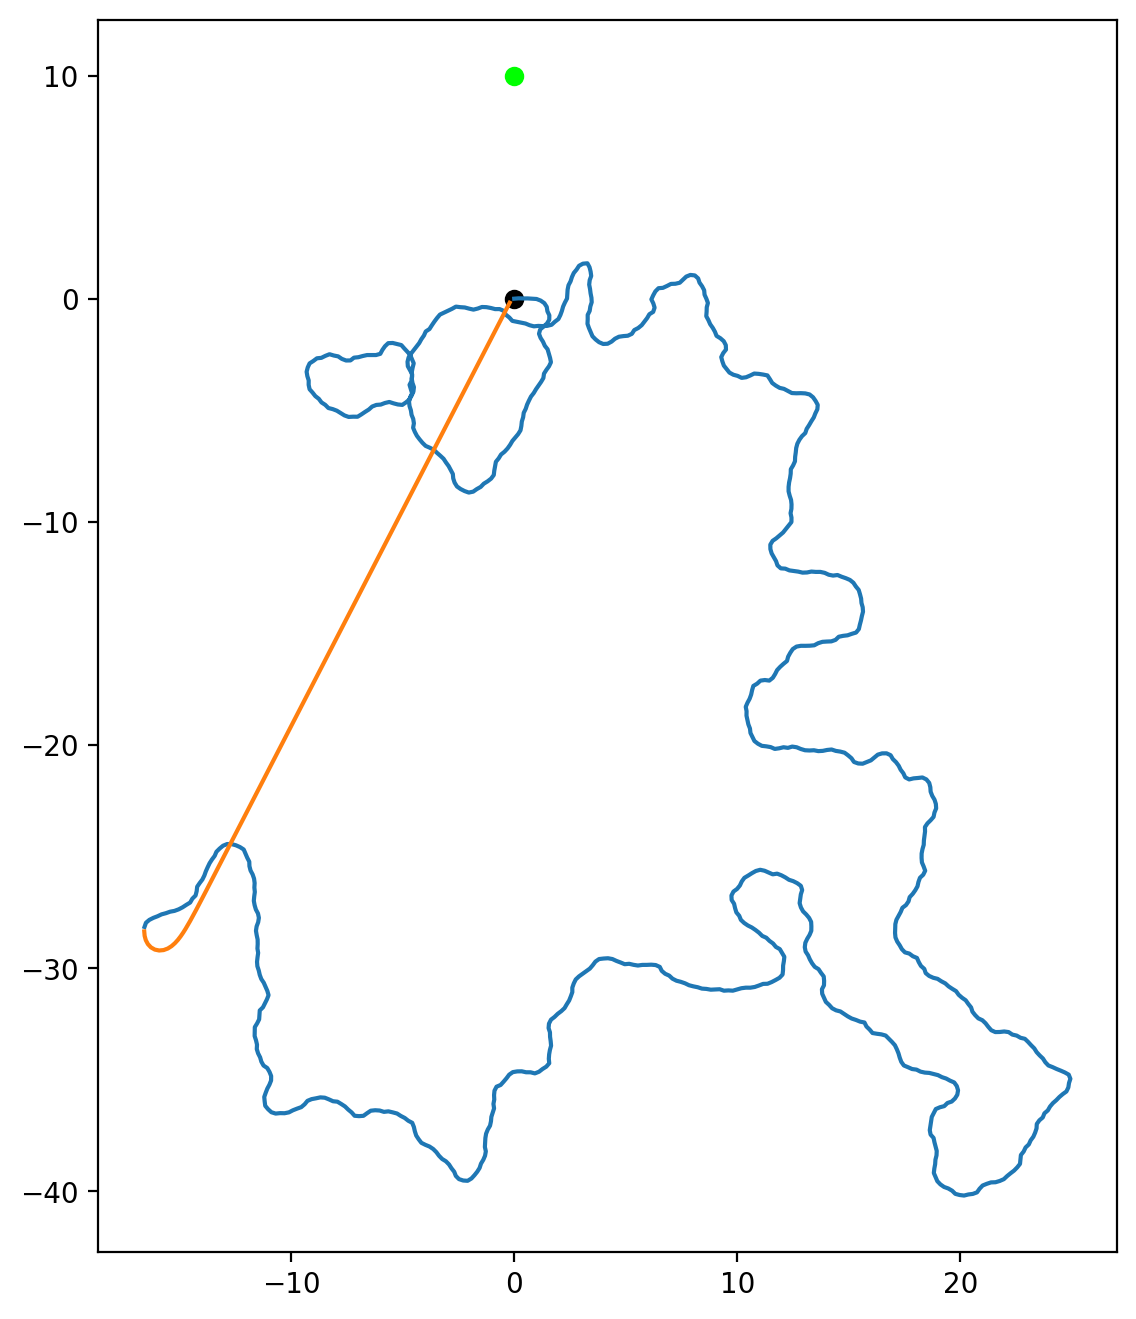

In [66]:
graph_test_navigation = AdaptiveVectorNavigation(1000, 18, 0)

position_sequence = np.empty((2000, 2))
position_sequence[0] = graph_test_navigation.position
for i in range(1999):
    graph_test_navigation.update_navigation()
    position_sequence[i+1] = graph_test_navigation.position
print(graph_test_navigation.discard_flag)
plot_single_navigation(position_sequence[:graph_test_navigation.trip_change_times[-1]], graph_test_navigation.feeder_position, graph_test_navigation.state_change_times[1])

# Test Noisy Path Integration

Determine scaling value for `head_vector_length`

In [57]:
scales = np.empty((100,))

for i in range(100):
    len_test_navigation = AdaptiveVectorNavigation(1000, 18, 0)

    true_len_sequence = np.empty((1500,))
    pred_len_sequence = np.empty((1500,))
    while len_test_navigation.num_resets < 1:
        len_test_navigation.update_navigation()
        true_len_sequence[len_test_navigation.time - 1] = np.sqrt(np.sum(len_test_navigation.position ** 2))
        pred_len_sequence[len_test_navigation.time - 1] = len_test_navigation.head_vector_length

    true_len_sequence = true_len_sequence[10:len_test_navigation.trip_change_times[-1] - 1]
    pred_len_sequence = pred_len_sequence[10:len_test_navigation.trip_change_times[-1] - 1]

    scales[i] = np.mean(true_len_sequence / pred_len_sequence)

print(np.mean(scales), np.var(scales))

# print(len_test_navigation.discard_flag)

# plt.plot(true_len_sequence)
# plt.plot(pred_len_sequence)
# plt.xlabel("time (s)")
# plt.ylabel("distance from home (m)")
# plt.show()

0.022345751566187726 1.4341527039264841e-08


Check comparison of `head_vector_angle`

True


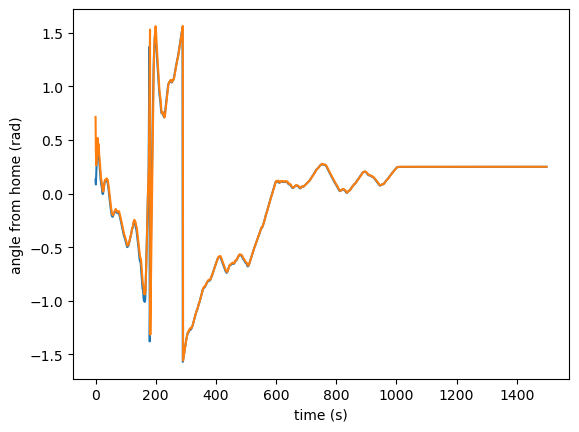

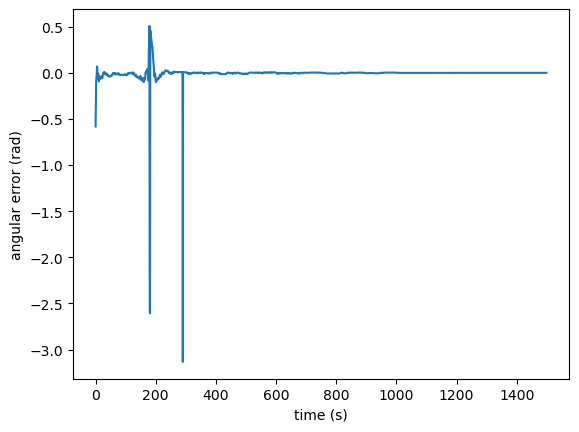

In [14]:
angle_test_navigation = AdaptiveVectorNavigation(1000, 18, 0)

true_angle_sequence = np.empty((1500,))
pred_angle_sequence = np.empty((1500,))
for i in range(1500):
    angle_test_navigation.update_navigation()
    true_angle_sequence[i] = np.arctan(angle_test_navigation.position[1] / angle_test_navigation.position[0])
    pred_angle_sequence[i] = angle_test_navigation.head_vector_angle

print(angle_test_navigation.discard_flag)
plt.plot(true_angle_sequence)
plt.plot(pred_angle_sequence)
plt.xlabel("time (s)")
plt.ylabel("angle from home (rad)")
plt.show()

plt.plot(true_angle_sequence - pred_angle_sequence)
plt.xlabel("time (s)")
plt.ylabel("angular error (rad)")
plt.show()

Examine total positional error over time

/tmp/ipykernel_12932/3366307594.py:11: RuntimeWarning: invalid value encountered in scalar divide
  true_angle_sequence[error_test_navigation.time - 1] = np.arctan(error_test_navigation.position[1] / error_test_navigation.position[0])


True


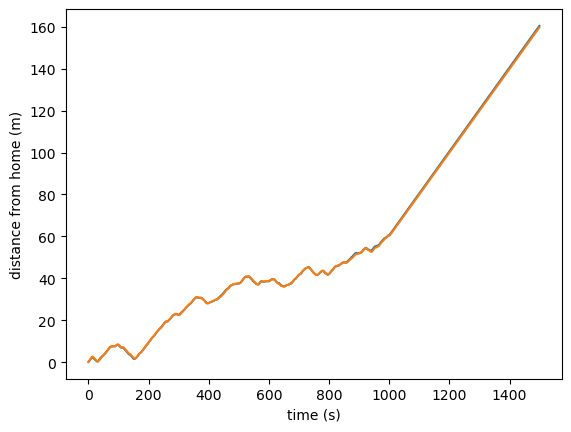

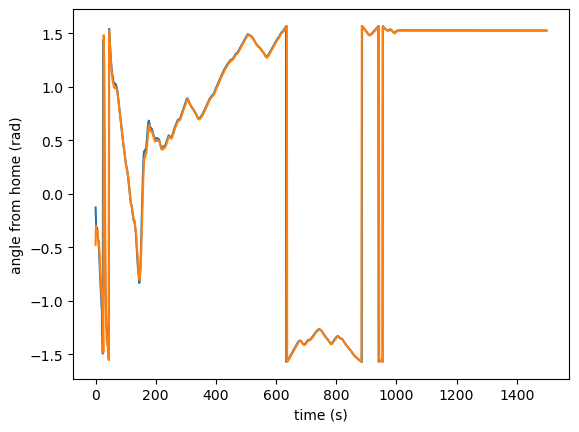

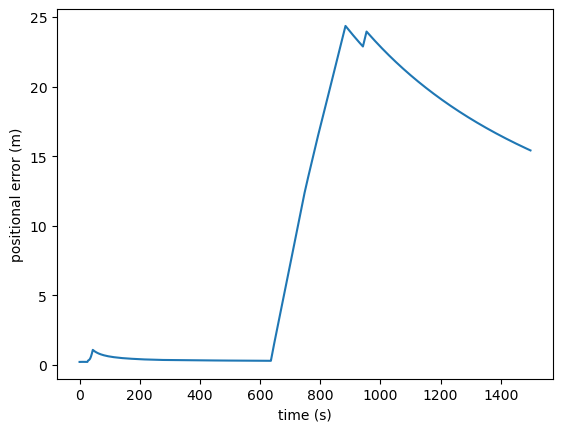

In [67]:
error_test_navigation = AdaptiveVectorNavigation(1000, 18, 0)

true_len_sequence = np.empty((1500,))
pred_len_sequence = np.empty((1500,))
true_angle_sequence = np.empty((1500,))
pred_angle_sequence = np.empty((1500,))
pos_error_seq = np.empty((1500,))

while error_test_navigation.num_resets < 1:
    true_len_sequence[error_test_navigation.time - 1] = np.sqrt(np.sum(error_test_navigation.position ** 2))
    true_angle_sequence[error_test_navigation.time - 1] = np.arctan(error_test_navigation.position[1] / error_test_navigation.position[0])
    error_test_navigation.update_navigation()
    pred_len_sequence[error_test_navigation.time - 1] = error_test_navigation.head_vector_length
    pred_angle_sequence[error_test_navigation.time - 1] = error_test_navigation.head_vector_angle
    pos_error_seq[error_test_navigation.time - 1] = error_test_navigation.total_pos_error / error_test_navigation.time

end_time = error_test_navigation.trip_change_times[-1]
print(error_test_navigation.discard_flag)

plt.plot(true_len_sequence[:end_time])
plt.plot(pred_len_sequence[:end_time])
plt.xlabel("time (s)")
plt.ylabel("distance from home (m)")
plt.show()

plt.plot(true_angle_sequence[:end_time])
plt.plot(pred_angle_sequence[:end_time])
plt.xlabel("time (s)")
plt.ylabel("angle from home (rad)")
plt.show()

plt.plot(pos_error_seq[:end_time])
plt.xlabel("time (s)")
plt.ylabel("positional error (m)")
plt.show()

Calculate error rates for different levels of sensory noise

In [13]:
noise_levels = [0.0, 0.01, 0.02, 0.05]
num_iterations = 1000
error_seq = np.empty((4, num_iterations))

for i, noise_level in enumerate(noise_levels):
    num_complete = 0
    while num_complete < num_iterations:
        nav = AdaptiveVectorNavigation(1000, 18, 0, noise_level)
        while nav.num_resets < 1:
            nav.update_navigation()
        if not nav.discard_flag:
            error_seq[i, num_complete] = nav.total_pos_error / nav.time
            num_complete += 1
        
        if num_complete % 250 == 0:
            print(noise_level, num_complete)

0.0 0
0.0 0
0.0 0
0.0 0
0.0 0
0.0 250
0.0 250
0.0 250
0.0 250
0.0 500
0.0 750
0.0 750
0.0 750
0.0 750
0.0 750
0.0 1000
0.01 0
0.01 0
0.01 0
0.01 0
0.01 250
0.01 250
0.01 250
0.01 250
0.01 500
0.01 500
0.01 500
0.01 500
0.01 750
0.01 1000
0.02 0
0.02 0
0.02 0
0.02 0
0.02 0
0.02 0
0.02 0
0.02 0
0.02 250
0.02 500
0.02 500
0.02 500
0.02 500
0.02 500
0.02 500
0.02 500
0.02 750
0.02 750
0.02 750
0.02 750
0.02 750
0.02 1000
0.05 0
0.05 0
0.05 250
0.05 250
0.05 500
0.05 500
0.05 500
0.05 500
0.05 500
0.05 500
0.05 500
0.05 500
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 750
0.05 1000


In [14]:
with open("positional_error.npy", "wb") as f:
    np.save(f, error_seq)

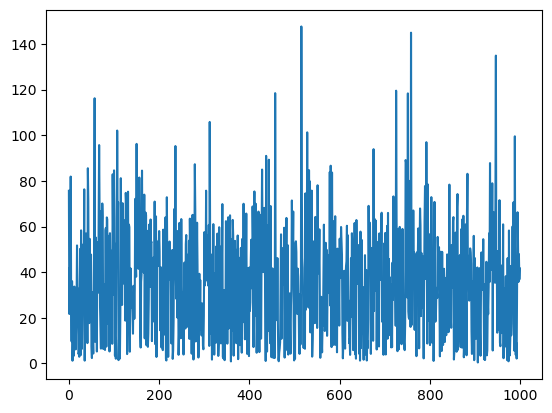

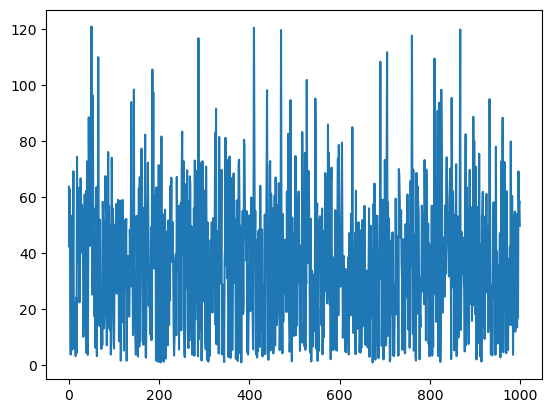

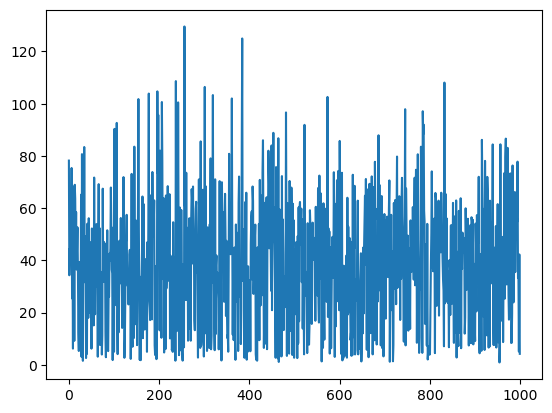

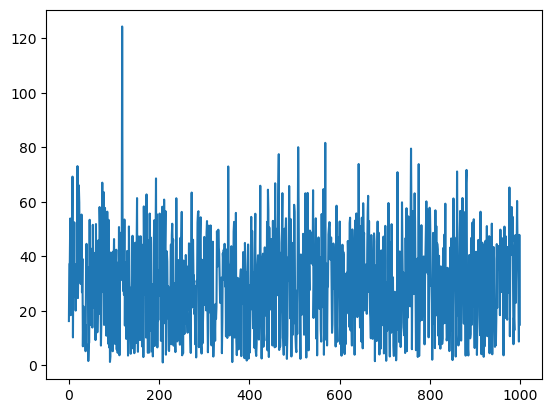

In [15]:
for i in range(4):
    plt.plot(error_seq[i])
    plt.show()

In [16]:
for level in error_seq:
    print(np.mean(level))

35.52514234355657
36.531118933608624
38.26932101504082
30.225470346938426


Calculate error rates for different levels of neural noise